### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# ML model (GOSS-LGBM) for Average Wind Speed

##  Read Me

This scripts contains ML model building steps for the weather variable `Average Wind Speed`. The ML model has been implemented using the [Gradient-based One-Side Sampling (GOSS)](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) algorithm from [LightGBM](https://lightgbm.readthedocs.io/en/stable/) library. Detail on why GOSS has been chosen for ML modeling has been described in `Discussion.ipynb`. The modeling involves the following steps-

1. Loading Data
2. additional data filtering (if required) 
3. Evaluation before model performance/relationship 
4. train-test data split 
5. Looking into Mutual Information (MI) score to select preliminary input variables
6. Model training + hyperparameter tuning
7. Train-test dataset performance evaluation
8. Evaluating model's predictor importance plot
9. Evaluation model performance for randomly selected dates from the test dataset
10. Estimating overall model perforamcne on test dataset
11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

__Note:__
- the functions for building ML model, hyperparameter optimization, model performance evaluation, and daily improved-resolution weather data generation (interpolation) can be found at `ML_utils.ipunb` script.
- the functions for building Multi-Layered Perceptrons (MLP) model with Pytorch library and generating daily improved-resolution weather datasets can be found at `NN_Pytorch.ipunb` script.
- the general functions for  for raster data handling, era5/twc data processing/compilation, and folder handling can be found at `general_utils.ipunb` script.

In [1]:
from ipynb.fs.full.general_utils import *
from ipynb.fs.full.ML_utils import *

-----------------

## 1. Loading Data

The `combined dataset` parquet file consists of weather datasets from ERA5 and TWC, along with topography and lat/lon data. Importing ERA5 and TWC datasets as well to briefly look into which variables belong to which source. 

In [2]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
twc_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_weatherdata.parquet'
combined_dataset =  '../../datasets/processed_parquet_data/cities_California/twc_era5_weather_data_cities_California.parquet'

twc_df =pd.read_parquet(twc_data)
era5_df = pd.read_parquet(era5_data)
combined_df = pd.read_parquet(combined_dataset)

print(f'TWC df columns: {twc_df.columns}')
print(f'ERA5 df columns: {era5_df.columns}')
print(f'TWC ERA5 df columns: {combined_df.columns}')

TWC df columns: Index(['index', 'avg_wind_speed', 'date', 'year', 'month', 'day', 'lon', 'lat',
       'avg_Rhumid', 'max_temp', 'min_temp'],
      dtype='object')
ERA5 df columns: Index(['MaxNet_SR', 'date', 'elevation', 'min_Rhumid', 'min_dew_temp',
       'max_atmPress', 'lat', 'lon', 'max_wind_speed', 'aspect', 'MaxDown_SR',
       'TotNet_SR', 'min_temp', 'max_temp', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid', 'etr',
       'avg_ST_L1', 'avg_snow_depth'],
      dtype='object')
TWC ERA5 df columns: Index(['index', 'avg_wind_speed_twc', 'date', 'year', 'month', 'day', 'lon',
       'lat', 'avg_Rhumid_twc', 'max_temp_twc', 'min_temp_twc', 'MaxNet_SR',
       'elevation', 'min_Rhumid', 'min_dew_temp', 'max_atmPress',
       'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'min_temp_era5',


------------------

## 2. Additional data filtering (if required)

No additional data filtering was required for this particular model.

-------------------------

## 3. Evaluation before model performance/relationship

We resample 28km ERA5 `Average Wind Speed` data to 4km resolution and compare with TWC `Average Wind Speed` (4km) Data to understand how the `R2` value looks like between these variables before implementing machine learning model. 

RMSE before modeling = 3.980
R2 before modeling= 0.442


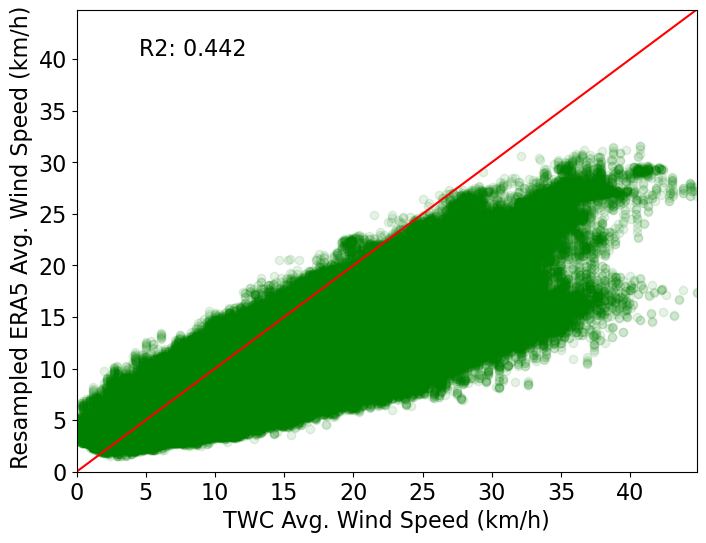

In [3]:
## ERA5 and TWC Total Precipitation relationship before RF model
rmse = calculate_rmse(Y_pred=combined_df['avg_wind_speed_era5'], Y_obsv=combined_df['avg_wind_speed_twc'])
r2 = calculate_r2(Y_pred=combined_df['avg_wind_speed_era5'], Y_obsv=combined_df['avg_wind_speed_twc'])

print('RMSE before modeling = {:.3f}'.format(rmse))
print('R2 before modeling= {:.3f}'.format(r2))

scatter_plot(Y_pred=combined_df['avg_wind_speed_era5'], Y_obsv=combined_df['avg_wind_speed_twc'], 
             xlabel='TWC Avg. Wind Speed (km/h)', 
             ylabel=' Resampled ERA5 Avg. Wind Speed (km/h)', title=None, 
             savedir=None, plot_name=None, color_format='go', alpha=0.1)

### Goal
The low R2 value shows that the ERA5 and TWC avg. wind speed value does't have a good correlation. We will try Machine Learning model to see if we can use ERA5 datasets as predictors to predict high resolution avg. wind speed using TWC avg. wind speed as the training data.

----------------

## 4. Making train-test split

__Input variables:__ Weather variables from ERA5 renanalysis dataset, along with topography, lat/lon, month datasets, have been used as input variables/predictors in the ML model. All TWC dataset, except the training data TWC `average wind speed`, has been removed from train-test datasets. 
__Observed/training data:__ TWC `average wind speed` has been used as the training/observed data.

In [3]:
drop_columns = ['index', 'year', 'day',
                'avg_Rhumid_twc', 'min_temp_twc', 'min_temp_twc', 'max_temp_twc',
                'avg_ST_L1', 'avg_SM_L1', 
                'avg_snow_depth', 'TotNet_SR',
                'eto', 'TotDown_SR', 'etr', 'min_atmPress', 'max_atmPress', 'avg_atmPress', 
                'slope', 'aspect']

# we are using the dataframe with 'avg_temp_twc' column as the input dataframe in the split_train_val_test_set_by_date() function
x_train, x_val, x_test, y_train, y_val, y_test, train_dates, validation_dates, test_dates= \
split_train_val_test_set_by_date(input_dataset_fp=combined_dataset, pred_attr='avg_wind_speed_twc', 
exclude_columns=drop_columns, test_perc=0.2, validation_perc=0)

Dropping Columns- ['index', 'year', 'day', 'avg_Rhumid_twc', 'min_temp_twc', 'min_temp_twc', 'max_temp_twc', 'avg_ST_L1', 'avg_SM_L1', 'avg_snow_depth', 'TotNet_SR', 'eto', 'TotDown_SR', 'etr', 'min_atmPress', 'max_atmPress', 'avg_atmPress', 'slope', 'aspect'] 

Predictors: Index(['MaxDown_SR', 'MaxNet_SR', 'avg_Cloud', 'avg_Rhumid_era5',
       'avg_dew_temp', 'avg_wind_dir', 'avg_wind_speed_era5', 'elevation',
       'lat', 'lon', 'max_Rhumid', 'max_dew_temp', 'max_temp_era5',
       'max_wind_speed', 'min_Rhumid', 'min_dew_temp', 'min_temp_era5',
       'min_wind_speed', 'month', 'total_precip'],
      dtype='object')


In [4]:
print('x_train length', len(x_train))
print('x_val length', len(x_val))
print('x_test length', len(x_test))
print(f'num. of training dates: {len(train_dates)}')
print(f'num. of validation dates: {len(validation_dates)}')
print(f'num. of test dates: {len(test_dates)}')

x_train length 3520439
x_val length 0
x_test length 879914
num. of training dates: 2286
num. of validation dates: 0
num. of test dates: 572


---------------

## 5. Looking into Mutual Information (MI) score to select preliminary input variables

`MI score` and `feature importance plot` are ways to determine which predictors are most important in predicting the target variable.  The `MI score` and `predictor/feature importance plot` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

avg_wind_speed_era5    0.746191
max_wind_speed         0.576147
min_wind_speed         0.432319
MaxDown_SR             0.212250
MaxNet_SR              0.193788
min_temp_era5          0.169717
month                  0.158686
max_temp_era5          0.129713
max_dew_temp           0.111147
avg_dew_temp           0.110868
avg_wind_dir           0.104122
avg_Cloud              0.103946
min_dew_temp           0.090124
avg_Rhumid_era5        0.077787
min_Rhumid             0.075652
max_Rhumid             0.071768
min_atmPress           0.062070
avg_atmPress           0.061351
max_atmPress           0.061113
lat                    0.055409
total_precip           0.052100
lon                    0.045059
dtype: float64

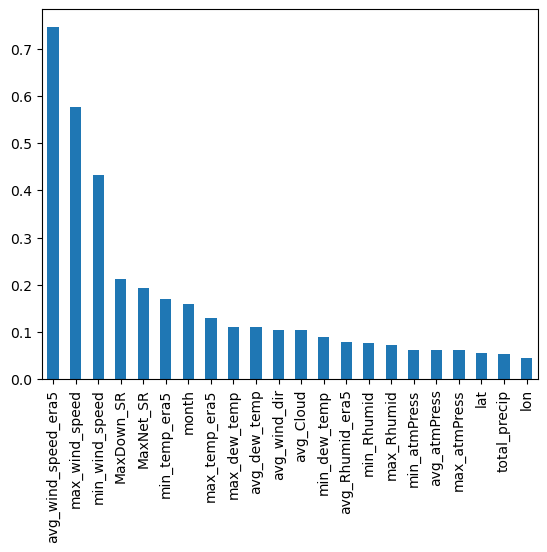

In [23]:
mutual_info_avgwind = calculate_plot_mutual_information(x_train=x_train, y_train=y_train)
mutual_info_avgwind

------------------

## 6. Model training+hyperparamter tuning

Tuned GOSS (LightGBM) model for 09 hyperparameters with 10-fold Randomized CV. A total of 500 combinations of hyperparameters were tested. The hyperparameter space can be found at `ML_utils.ipynb` script. 

In [5]:
# the hyperparameters provided in the following dictionary have been set by hyperparameter tuning
lgbm_param_dict = {'n_estimators': 250,
                   'max_depth': 13,
                   'learning_rate': 0.05,
                   'subsample': 0.7,
                   'colsample_bytree': 0.8,
                   'colsample_bynode': 0.7 ,
                   'path_smooth': 0.2,
                   'num_leaves': 70,
                   'min_child_samples': 40,
                   'data_sample_strategy': 'goss'}
# when tuning hyperparameters set params_dict=None.
trained_lgbm_windspeed = train_model(x_train, y_train, params_dict=lgbm_param_dict, model='lgbm', n_jobs=-1,
                                     load_model=False, save_model=True, save_folder='./saved_models', 
                                     save_name='lgbm_avg_wind_speed',
                                     # hyperparameter tuning arguments
                                     tune_hyperparameters=False, repeated_Kfold=False, n_folds=10, n_iter=50, n_repeats=5)

[LightGBM] [Info] Total Bins 4531
[LightGBM] [Info] Number of data points in the train set: 3520439, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 10.551407
Train RMSE = 1.568
Train R2 = 0.913
model training time 0.367 mins


In [6]:
trained_lgbm_windspeed

LGBMRegressor(colsample_bynode=0.7, colsample_bytree=0.8,
              data_sample_strategy='goss', deterministic=True,
              force_row_wise=True, learning_rate=0.05, max_depth=13,
              min_child_samples=40, n_estimators=250, n_jobs=-1, num_leaves=70,
              path_smooth=0.2, random_state=0, subsample=0.7,
              tree_learner='serial')

----------------

## 7. Train-test dataset perforamnce evaluation

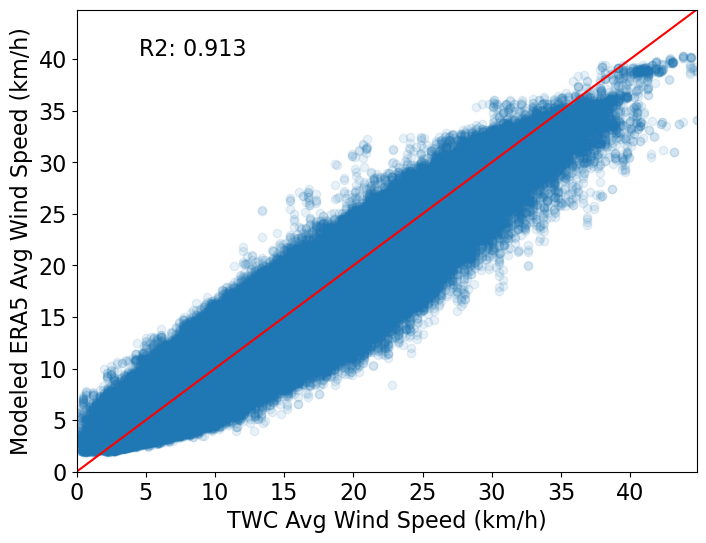

In [7]:
# Performance on train dataset
y_pred_train = trained_lgbm_windspeed.predict(x_train)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_train, 
             xlabel='TWC Avg Wind Speed (km/h)', ylabel='Modeled ERA5 Avg Wind Speed (km/h)', title=None, 
             savedir=None, plot_name=None, alpha=0.1)

Test RMSE = 1.706
Test R2 = 0.897


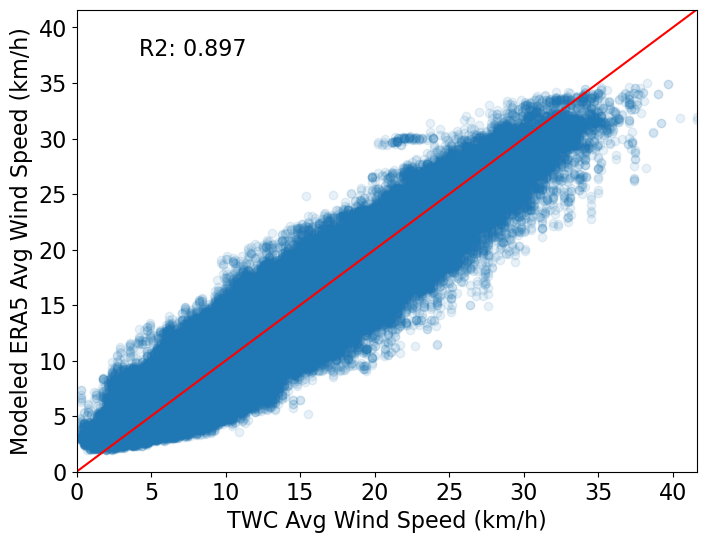

In [8]:
# Performance on test dataset
y_pred_test = trained_lgbm_windspeed.predict(x_test)
print('Test RMSE = {:.3f}'.format(calculate_rmse(Y_pred=y_pred_test, Y_obsv=y_test)))
print('Test R2 = {:.3f}'.format(calculate_r2(Y_pred=y_pred_test, Y_obsv=y_test)))


scatter_plot(Y_pred=y_pred_test, Y_obsv=y_test, 
             xlabel='TWC Avg Wind Speed (km/h)', ylabel='Modeled ERA5 Avg Wind Speed (km/h)', title=None, 
             savedir=None, plot_name=None, alpha=0.1)

------------

## 8. Evaluating model's predictor importance plot

The `predictor/feature importance plot` is a way of seeing which input variables are regarded the most important by the model. The predictor importance plot here is based on `Impurity-based feature importance` which is prone to high-cardinality. I would recoomend looking into [permutation importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) to have a more rigorous understanding of feature importance. The `predictor/feature importance plot` and `MI score` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

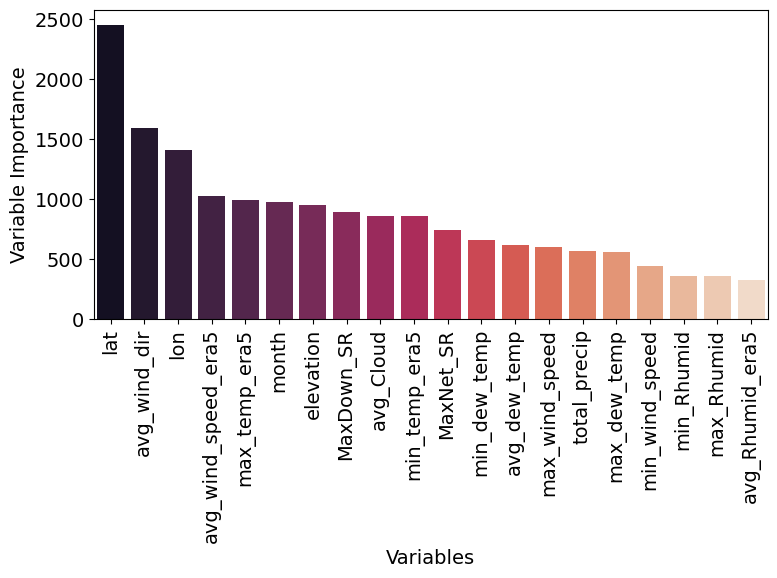

In [9]:
# preditor importance plot
plot_predictor_importance(trained_model=trained_lgbm_windspeed, x_train=x_train, outdir=None, predictor_imp_keyword='lgbm')

------------------

## 9. Evaluation model performance for randomly selected dates from the test dataset

Our objective is to improve spatial resolution of daily weather datasets. So, we chcek model performance on randomly selected dataes from the test datasets.

In [11]:
test_dates[1:20]

[20201231,
 20201220,
 20210204,
 20230221,
 20160520,
 20160830,
 20170223,
 20160207,
 20191225,
 20180628,
 20151114,
 20210714,
 20191122,
 20210105,
 20190310,
 20190323,
 20191229,
 20220806,
 20171025]

In [12]:
# to check if a date is in test dataset
if 20220816 in test_dates:
    print(True)

True


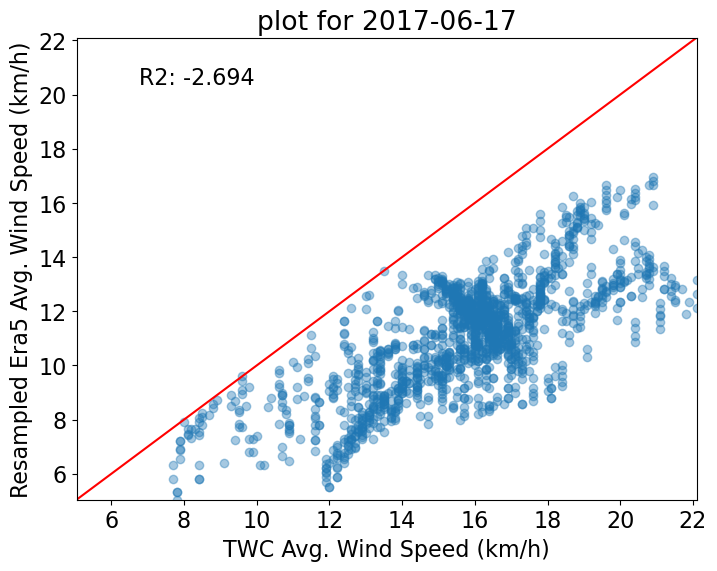

In [9]:
twc_era5_df_sample2 = combined_df[combined_df.date==20170617]
era5_maxtemp = twc_era5_df_sample2['avg_wind_speed_era5'] 
y_02 = twc_era5_df_sample2[['avg_wind_speed_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Avg. Wind Speed (km/h)', ylabel='Resampled Era5 Avg. Wind Speed (km/h)', 
             title='plot for 2017-06-17', alpha=0.4)

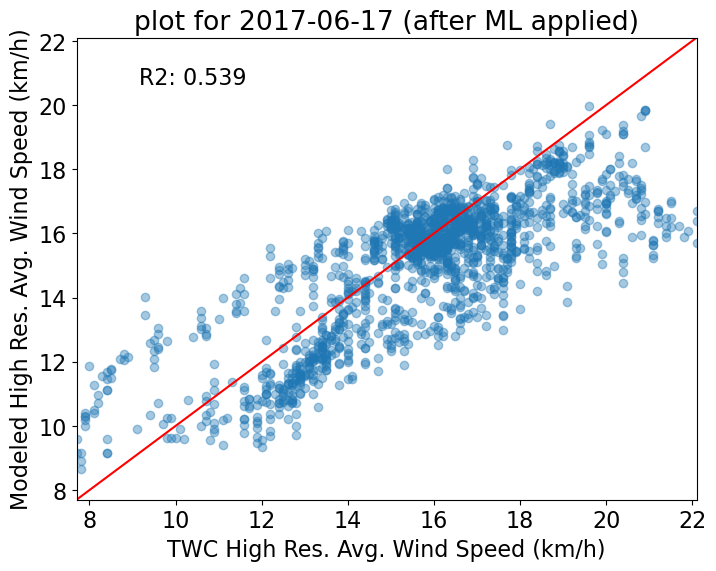

In [10]:
twc_era5_df_sample2 = combined_df[combined_df.date==20170617]
x_02 = twc_era5_df_sample2[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample2[['avg_wind_speed_twc']].values 

y_pred_train = trained_lgbm_windspeed.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC High Res. Avg. Wind Speed (km/h)', ylabel='Modeled High Res. Avg. Wind Speed (km/h)', 
             title='plot for 2017-06-17 (after ML applied)', alpha=0.4)

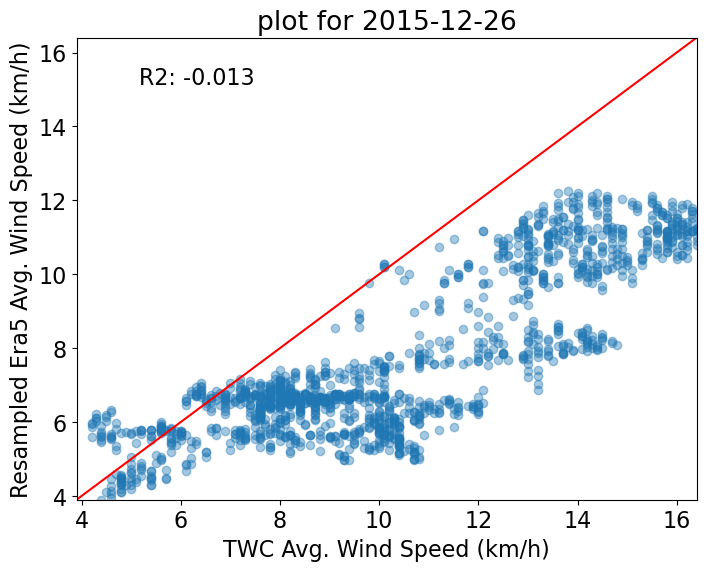

In [11]:
twc_era5_df_sample2 = combined_df[combined_df.date==20151226]
era5_maxtemp = twc_era5_df_sample2['avg_wind_speed_era5'] 
y_02 = twc_era5_df_sample2[['avg_wind_speed_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Avg. Wind Speed (km/h)', ylabel='Resampled Era5 Avg. Wind Speed (km/h)', 
             title='plot for 2015-12-26', alpha=0.4)

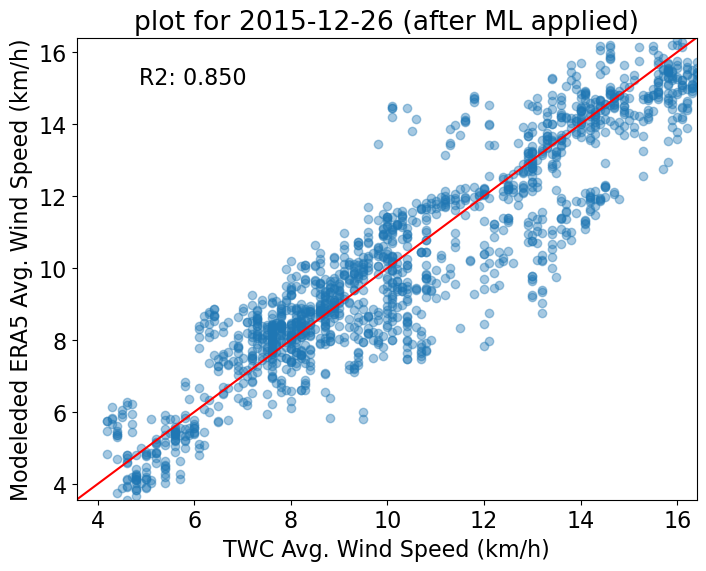

In [9]:
twc_era5_df_sample2 = combined_df[combined_df.date==20151226]
x_02 = twc_era5_df_sample2[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample2[['avg_wind_speed_twc']].values 

y_pred_train = trained_lgbm_windspeed.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Avg. Wind Speed (km/h)', ylabel='Modeleded ERA5 Avg. Wind Speed (km/h)', 
             title='plot for 2015-12-26 (after ML applied)', alpha=0.4)

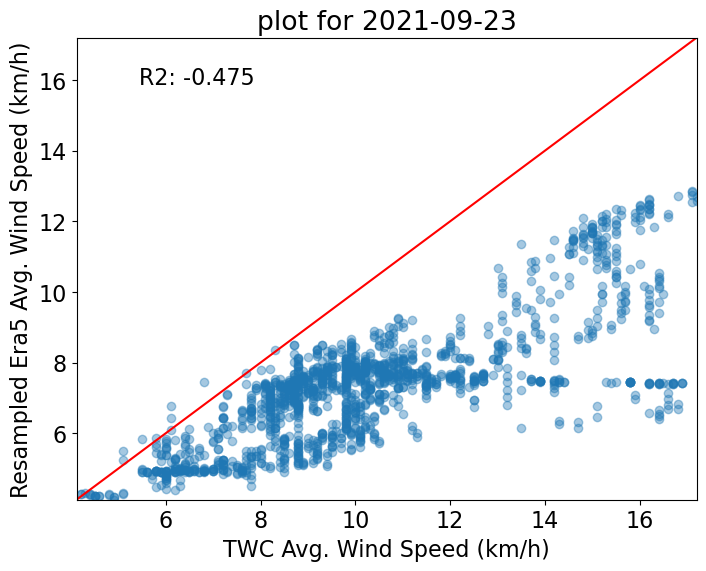

In [12]:
twc_era5_df_sample2 = combined_df[combined_df.date==20210923]
era5_maxtemp = twc_era5_df_sample2['avg_wind_speed_era5'] 
y_02 = twc_era5_df_sample2[['avg_wind_speed_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Avg. Wind Speed (km/h)', ylabel='Resampled Era5 Avg. Wind Speed (km/h)', 
             title='plot for 2021-09-23', alpha=0.4)

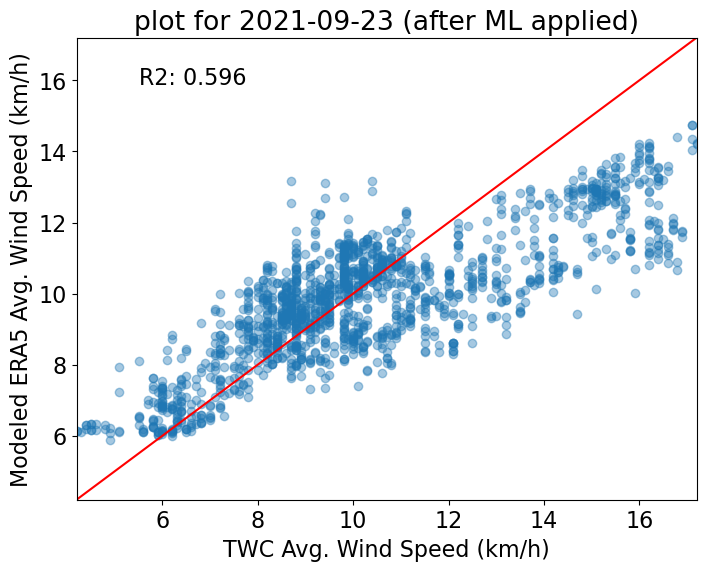

In [13]:
twc_era5_df_sample2 = combined_df[combined_df.date==20210923]
x_02 = twc_era5_df_sample2[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample2[['avg_wind_speed_twc']].values 

y_pred_train = trained_lgbm_windspeed.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Avg. Wind Speed (km/h)', ylabel='Modeled ERA5 Avg. Wind Speed (km/h)', 
             title='plot for 2021-09-23 (after ML applied)', alpha=0.4)

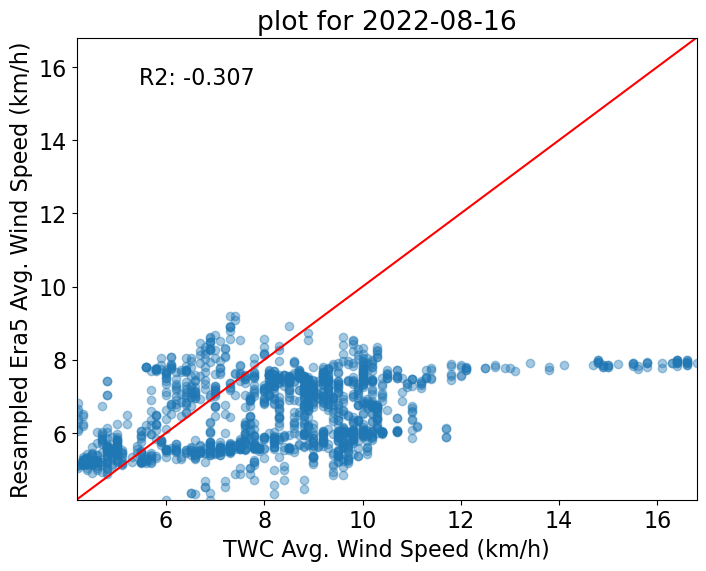

In [14]:
twc_era5_df_sample2 = combined_df[combined_df.date==20220816]
era5_maxtemp = twc_era5_df_sample2['avg_wind_speed_era5'] 
y_02 = twc_era5_df_sample2[['avg_wind_speed_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Avg. Wind Speed (km/h)', ylabel='Resampled Era5 Avg. Wind Speed (km/h)', 
             title='plot for 2022-08-16', alpha=0.4)

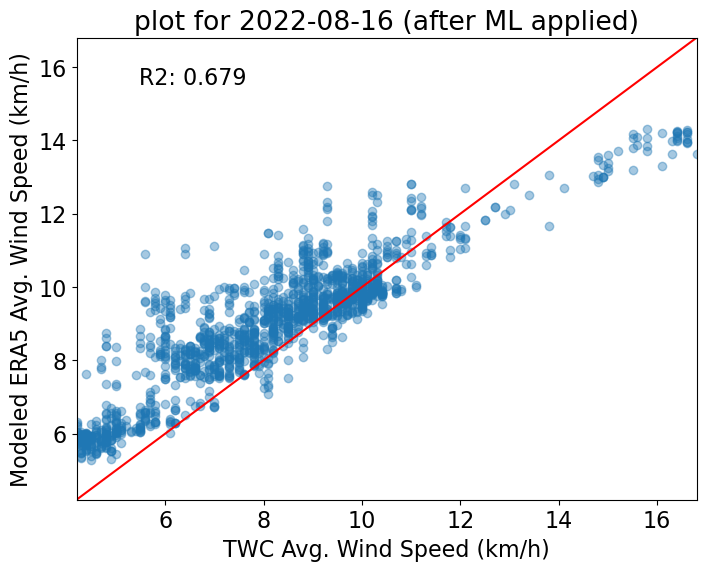

In [15]:
twc_era5_df_sample2 = combined_df[combined_df.date==20220816]
x_02 = twc_era5_df_sample2[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample2[['avg_wind_speed_twc']].values

y_pred_train = trained_lgbm_windspeed.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Avg. Wind Speed (km/h)', ylabel='Modeled ERA5 Avg. Wind Speed (km/h)', 
             title='plot for 2022-08-16 (after ML applied)', alpha=0.4)

__The plots of before and after modeling performance for randomly selected dates from test dataset shows that the model is performing quite well for individual dates.__

-------------

## 10. Estimating overall model perforamcne on test dataset

Here, we are looking into before and after modeling R2 score for all dates in the test dataset.

In [18]:
result_calc_test_dataset(trained_ml_model=trained_lgbm_windspeed, list_test_dates=test_dates, x_train=x_train, 
                         combined_dataset=combined_dataset, era5_target_variable='avg_wind_speed_era5', 
                         twc_target_variable='avg_wind_speed_twc', 
                         output_csv='./saved_models/avg_wind_speed_test_results.csv')

572 number of total dates in test dataset
334 days have R2 > 0.6
386 days have R2 > 0.5
455 days have R2 > 0.3


,date,before_ML_R2,after_ML_R2
0,20200925,-0.167465,0.857961
1,20181018,0.343808,0.626740
2,20201001,-0.046217,0.156605
3,20191215,0.515781,0.856692
4,20161127,-0.639751,0.758999
...,...,...,...
567,20201011,-2.234074,0.560136
568,20201222,0.507490,0.869972
569,20230401,-0.287753,0.699702
570,20181004,-3.102546,0.479257


In [19]:
import seaborn as sns

results_csv = './saved_models/avg_wind_speed_test_results.csv'
results_df = pd.read_csv(results_csv)

R2_below_zero_before_model = len(results_df[results_df['before_ML_R2']<0])
R2_below_zero_after_model = len(results_df[results_df['after_ML_R2']<0])

print(f'Before ML model {R2_below_zero_before_model} R2 remains negative')
print(f'After ML model {R2_below_zero_after_model} R2 remains negative')

Before ML model 437 R2 remains negative
After ML model 61 R2 remains negative


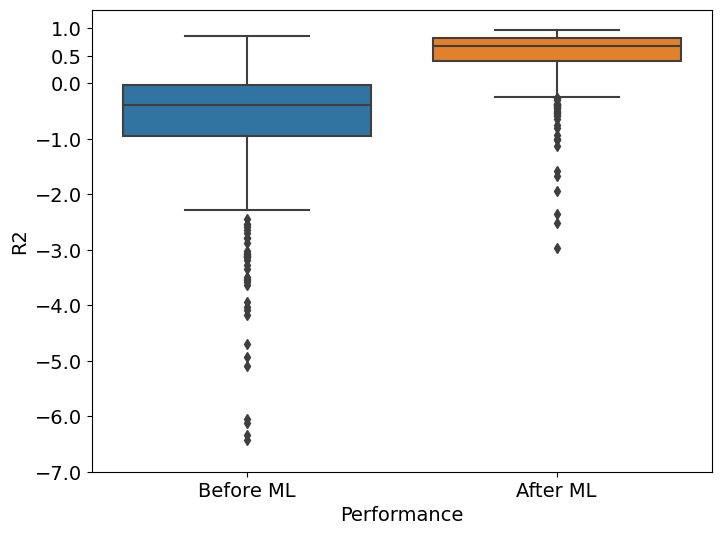

In [20]:
# Boxplot of before and after ML performance
results_df = results_df[['before_ML_R2', 'after_ML_R2']]
results_df = results_df.rename(columns={'before_ML_R2': 'Before ML', 'after_ML_R2': 'After ML'})
results_df = results_df[results_df['Before ML']>-7]

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='variable', y='value', data=pd.melt(results_df))
ax.set_xlabel('Performance')
ax.set_ylabel('R2')
ax.set_yticks([-7, -6, -5, -4, -3, -2, -1, 0, 0.5, 1])

__The boxplot of before and after modeling R2 proves that the model is performing very well. From negative to very low R2 values, the model increases the R2 value which proves that the model interpolates the the daily weather data at high-resolution succesfully.__

-----------------

## 11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

In [22]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
ref_raster = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/avg_wind_speed/avg_wind_speed_20150630.tif'
output_folder = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_wind_speed'

run_model_to_generate_prediction(trained_ml_model=trained_lgbm_windspeed, x_train=x_train, 
                                 predictor_era5_dataset=era5_data, ref_raster=ref_raster, 
                                 output_folder=output_folder, variable_name_keyword='avg_wind_speed')

Generating model interpolated daily rasters...
All daily rasters generated


### Visualization of downscaled results 

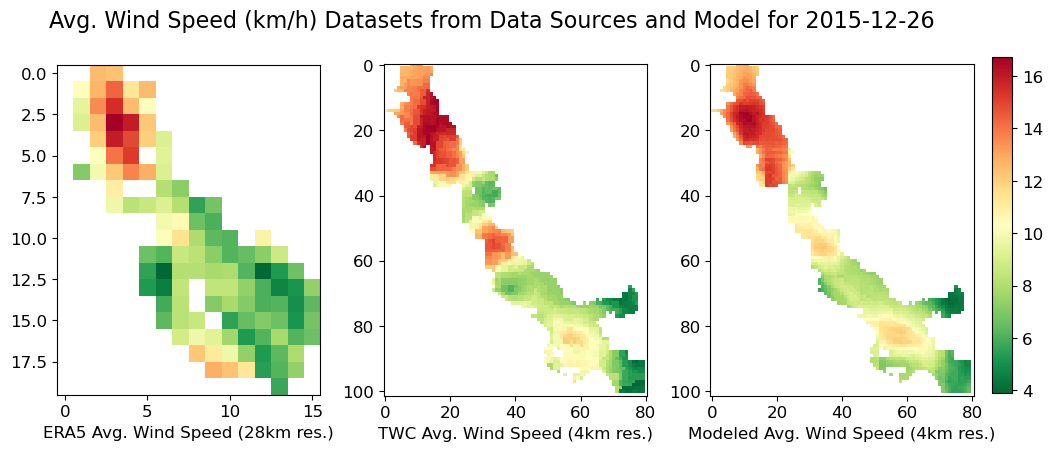

In [3]:
era5_data = '../../datasets/weather_raster_data/cities_California/era5_data/original_28km_rasters/avg_wind_speed/avg_wind_speed_20151226.tif'
twc_data = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/avg_wind_speed/avg_wind_speed_20151226.tif'
downscaled_data = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_wind_speed/avg_wind_speed_20151226.tif'


plot_era5_twc_downscaled_rasters(era5_data, twc_data, downscaled_data,  
                                 title= 'Avg. Wind Speed (km/h) Datasets from Data Sources and Model for 2015-12-26',
                                 suptitle_pos=0.75,
                                 xlabels=['ERA5 Avg. Wind Speed (28km res.)',
                                          'TWC Avg. Wind Speed (4km res.)',
                                          'Modeled Avg. Wind Speed (4km res.)'],
                                 cbar_axes_pos=[1, 0.27, 0.02, 0.42])